In [47]:
import os
import requests
# import boto3
# import botocore
# from config import cg_headers
import pandas as pd
import numpy as np
import datetime as dt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LSTM, Bidirectional, TimeDistributed, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics
import lightgbm as lgb

from lightgbm import LGBMRegressor, cv
from lightgbm import early_stopping, log_evaluation
# import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# confirm GPU usage with tensorflow
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
cols = ['date','unix', 'time_id', '3nn_avg_RV', '5nn_avg_RV', '10nn_avg_RV']
dataset = pd.read_parquet("/content/btcsusd_15m_features.parquet").drop(columns = cols)
dataset

,RV,high,low,volume_BTC,volume_USDT,tradecount,premium,distance_to_LL75,distance_to_SL75,distance_to_LL50,...,5nn_avg_volume_USDT,5nn_avg_volume_BTC,5nn_avg_tradecount,10nn_avg_distance_to_LL75,10nn_avg_distance_to_SL75,10nn_avg_distance_to_LL25,10nn_avg_distance_to_SL25,10nn_avg_volume_USDT,10nn_avg_volume_BTC,10nn_avg_tradecount
0,0.002757,47750.00,47463.63,294.05935,1.400409e+07,9837,-0.000407,0.007853,-0.007685,0.014517,...,5.385501e+07,1503.300968,39805.6,0.070695,-0.069093,0.310581,-0.309251,1.221593e+08,3155.255802,90837.0
1,0.002071,47578.79,47381.12,324.85868,1.542778e+07,8682,-0.000482,0.007839,-0.007776,0.014503,...,4.805413e+07,1162.826368,35190.4,0.070617,-0.069993,0.310501,-0.310128,1.194552e+08,2896.157655,83938.5
2,0.002317,47699.39,47491.43,266.91970,1.270986e+07,8173,-0.000244,0.007819,-0.007800,0.014482,...,4.265117e+07,982.993320,36988.8,0.070345,-0.070195,0.310221,-0.310324,1.057117e+08,2570.233590,85450.5
3,0.001666,47700.00,47575.69,196.67044,9.368818e+06,6229,-0.000132,0.007843,-0.007963,0.014507,...,3.489508e+07,833.482080,26931.2,0.070657,-0.071696,0.310543,-0.311785,8.135013e+07,1945.133721,64175.4
4,0.002355,47641.83,47425.65,138.49194,6.580935e+06,6430,-0.000199,0.008087,-0.007685,0.014752,...,3.638166e+07,902.333528,34261.6,0.072583,-0.069197,0.312519,-0.309353,8.387275e+07,2378.987379,75122.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35036,0.000877,16625.00,16600.80,1034.88397,1.719247e+07,33245,-0.001123,0.008161,-0.008222,0.014826,...,7.142290e+07,4161.973192,130721.6,0.073477,-0.073931,0.313437,-0.313960,1.605078e+08,9333.352071,292314.6
35037,0.000579,16621.97,16604.65,843.34258,1.401184e+07,30163,-0.000919,0.008198,-0.008194,0.014864,...,5.820948e+07,3409.228344,118460.0,0.073744,-0.073772,0.313711,-0.313805,1.316235e+08,7795.657656,265881.6
35038,0.000716,16619.20,16602.61,1148.99010,1.908553e+07,35338,-0.000686,0.008198,-0.008165,0.014864,...,8.019831e+07,4523.322624,139964.8,0.073781,-0.073503,0.313748,-0.313543,1.761506e+08,10255.980852,318089.7
35039,0.000595,16621.44,16603.31,819.39830,1.361085e+07,29652,-0.000572,0.008209,-0.008220,0.014874,...,5.729586e+07,3362.656680,117798.4,0.073880,-0.073957,0.313850,-0.313985,1.267117e+08,7525.667583,267705.9


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35041 entries, 0 to 35040
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   RV                         35041 non-null  float64
 1   high                       35041 non-null  float64
 2   low                        35041 non-null  float64
 3   volume_BTC                 35041 non-null  float64
 4   volume_USDT                35041 non-null  float64
 5   tradecount                 35041 non-null  int64  
 6   premium                    35041 non-null  float64
 7   distance_to_LL75           35041 non-null  float64
 8   distance_to_SL75           35041 non-null  float64
 9   distance_to_LL50           35041 non-null  float64
 10  distance_to_SL50           35041 non-null  float64
 11  distance_to_LL25           35041 non-null  float64
 12  distance_to_SL25           35041 non-null  float64
 13  75L_liquidated             35041 non-null  int

In [5]:
dataset.columns

Index(['RV', 'high', 'low', 'volume_BTC', 'volume_USDT', 'tradecount',
       'premium', 'distance_to_LL75', 'distance_to_SL75', 'distance_to_LL50',
       'distance_to_SL50', 'distance_to_LL25', 'distance_to_SL25',
       '75L_liquidated', '75S_liquidated', '50L_liquidated', '50S_liquidated',
       '25L_liquidated', '25S_liquidated', 'close', '3nn_avg_distance_to_LL75',
       '3nn_avg_distance_to_SL75', '3nn_avg_distance_to_LL25',
       '3nn_avg_distance_to_SL25', '3nn_avg_volume_USDT', '3nn_avg_volume_BTC',
       '3nn_avg_tradecount', '5nn_avg_distance_to_LL75',
       '5nn_avg_distance_to_SL75', '5nn_avg_distance_to_LL25',
       '5nn_avg_distance_to_SL25', '5nn_avg_volume_USDT', '5nn_avg_volume_BTC',
       '5nn_avg_tradecount', '10nn_avg_distance_to_LL75',
       '10nn_avg_distance_to_SL75', '10nn_avg_distance_to_LL25',
       '10nn_avg_distance_to_SL25', '10nn_avg_volume_USDT',
       '10nn_avg_volume_BTC', '10nn_avg_tradecount'],
      dtype='object')

In [6]:
data = dataset.copy()

In [51]:
class TimeSeriesDataSplitter:
    """
    A class used to split time series data into training, validation, and testing sets.
    Parameters:
    train_size (float): The proportion of data to be used for training
    val_size (float, optional): The proportion of data to be used for validation. Defaults to None.
    test_size (float): The proportion of data to be used for testing.
    """

    def __init__(self, train_size, test_size=None, val_size=None):
        self.train_size = train_size
        self.test_size = test_size
        self.val_size = val_size

    def split(self, data):
        """
        Splits the given time series data into training, validation, and testing sets.
        Parameters:
        data (DataFrame): The time series data to be split.
        Returns:
        tuple: A tuple containing the training data, validation data (if val_size is not None), and the testing data.
        """
        train_end_index = int(self.train_size * len(data))
        test_start_index = train_end_index
        if self.val_size is not None:
            val_end_index = test_start_index + int(self.val_size * len(data))
            train_data = data.iloc[:train_end_index, :]
            val_data = data.iloc[test_start_index:val_end_index, :]
            test_data = data.iloc[val_end_index:, :]
            return train_data, val_data, test_data
        else:
            train_data = data.iloc[:train_end_index, :]
            test_data = data.iloc[test_start_index:, :]
            return train_data, test_data

    def time_series_cross_validation(self, data, n_splits=5):
        """
        Performs time series cross-validation.
        Parameters:
        data (DataFrame): The time series data to be split.
        n_splits (int): The number of splits for cross-validation. Default is 5.
        Returns:
        generator: A generator that yields train and validation sets for each split.
        """
        tscv = TimeSeriesSplit(n_splits=n_splits)
        for train_index, val_index in tscv.split(data):
            yield data.iloc[train_index], data.iloc[val_index]

class CNNLSTMmodel:
    """
    A class to build, compile, train and evaluate a CNN-LSTM model for time series prediction.

    Attributes:
    -----------
    target_col : str
        The name of the target column.
    feature_cols : list of str
        The list of names of the feature columns.
    scaler : object
        The MinMaxScaler object used to scale the data.
    model : object
        The built and compiled model object.

    Methods:
    --------
    preprocess_data(X):
        Reshapes and scales the input data X.
    build_model():
        Builds the CNN-LSTM model.
    compile_model(loss, optimizer):
        Compiles the model.
    train_model(X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping_patience, model_checkpoint_filepath, compile_loss, compile_optimizer):
        Trains the model and saves the best weights.
    evaluate_model(X_test, y_test):
        Evaluates the model on the test data and prints the test loss.
    train_and_evaluate_models(X_train, y_train, X_test, y_test, num_models, epochs, batch_size, early_stopping_patience, save_best_only, model_checkpoint_filepath, compile_loss, compile_optimizer):
        Trains and evaluates multiple models, and returns the validation losses of all models.
    predict(X):
        Predicts the target variable for the input data X.

  """

    def __init__(self, target_col, feature_cols):
        self.target_col = target_col
        self.feature_cols = feature_cols
        self.scaler = MinMaxScaler()
        self.model = None

    def preprocess_data(self, X):
        # flatten data to allow for scaler to accept as input, then reshape back to tensor shape for cnn+lstm
        X_flatten = X.reshape((X.shape[0], -1))
        X_scaled = self.scaler.fit_transform(X_flatten)
        X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, 1, -1))
        return X_reshaped

    def build_model(self):
        model = Sequential()
        model.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu'),
                                  input_shape=(None, 1, len(self.feature_cols))))
        model.add(TimeDistributed(MaxPooling1D(pool_size=1)))   
        model.add(TimeDistributed(
            Conv1D(filters=64, kernel_size=1, activation='relu')))
        model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
        model.add(TimeDistributed(
            Conv1D(filters=32, kernel_size=1, activation='relu')))
        model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
        model.add(TimeDistributed(Flatten()))
        model.add(Bidirectional(
            LSTM(128, recurrent_dropout=0.2, return_sequences=True)))
        model.add(Dropout(0.4))
        model.add(Bidirectional(
            LSTM(128, recurrent_dropout=0.2, return_sequences=False)))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='linear'))
        self.model = model
  
    def compile_model(self, loss='mean_squared_error', optimizer='adam'):
        self.model.compile(loss=loss, optimizer=optimizer)

    def train_model(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32, early_stopping_patience=10,
                    model_checkpoint_filepath='best_model.h5', compile_loss='mean_squared_error', compile_optimizer='adam'):

        self.build_model()
        self.compile_model(loss=compile_loss, optimizer=compile_optimizer)

        callbacks = [EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),
                     ModelCheckpoint(filepath=model_checkpoint_filepath, save_best_only=True, save_weights_only=True)]
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks,
                                 validation_data=(X_val, y_val))

        return history

    def evaluate_model(self, X_test, y_test):
        loss = self.model.evaluate(X_test, y_test)
        print(f"Test loss: {loss}")

    def train_and_evaluate_models(self, X_train, y_train, X_test, y_test, num_models=5, epochs=100, batch_size=32,
                                  early_stopping_patience=10, save_best_only=True, model_checkpoint_filepath='best_cnn_lstm.h5', compile_loss='mean_squared_error', compile_optimizer='adam'):
        best_loss = float('inf')
        best_model = None
        model_losses = []
        # train n number of models and save the model losses to compare perfomances
        for i in range(num_models):
            print(f"Training model {i + 1}")
            # Train the model and get the training history
            history = self.train_model(X_train, y_train, X_test, y_test, epochs=epochs, batch_size=batch_size,
                                       early_stopping_patience=early_stopping_patience,
                                       model_checkpoint_filepath=model_checkpoint_filepath, compile_loss=compile_loss, compile_optimizer=compile_optimizer)

            # Evaluate the model on the test data and print the results
            self.evaluate_model(X_test, y_test)

            # Get the validation loss for the trained model
            loss = history.history['val_loss'][-1]
            print(f"Validation loss for model {i + 1}: {loss}")
            model_losses.append(loss)
            # Update the best model if the current model has a lower validation loss
            if loss < best_loss:
                best_loss = loss
                best_model = self.model
        # Set the best model as the current model for further use
        self.model = best_model

        print("Training complete.")
        return model_losses

    def predict(self, X):
        X_reshaped = self.preprocess_data(X)
        y_pred = self.model.predict(X_reshaped)
        return y_pred


class LightGBMModel:
    """
    A class for training and predicting using a LightGBM model for regression.

    Attributes:
    num_leaves (int): The maximum number of leaves in one tree.
    learning_rate (float): Learning rate used in the training process.
    n_estimators (int): Number of boosting iterations.
    model (LGBMRegressor): The trained LightGBM model.
    cv_result (dict): A dictionary with the results of the cross-validation.

    Methods:
    train(X_train, y_train, X_val=None, y_val=None): Trains the LightGBM model with the specified parameters.
    predict(X_test): Predicts using the trained LightGBM model.
    plot_feature_importance(X_train): Plots the feature importance of the trained model.
    """

    def __init__(self, num_leaves=31, learning_rate=0.05, n_estimators=100):
        """
        Initializes a LightGBMModel object with the specified hyperparameters.

        Args:
        num_leaves (int): The maximum number of leaves in one tree. Default is 31.
        learning_rate (float): Learning rate used in the training process. Default is 0.05.
        n_estimators (int): Number of boosting iterations. Default is 100.
        """
        self.num_leaves = num_leaves
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.model = None
        self.cv_result = None

    def train(self, X_train, y_train, X_val=None, y_val=None):
      """
      Trains the LightGBM model with the specified parameters.
      Args:
      X_train (numpy.ndarray): The training data of shape (n_samples, n_features).
      y_train (numpy.ndarray): The target values of the training data of shape (n_samples, ).
      X_val (numpy.ndarray): The validation data of shape (n_samples, n_features). Default is None.
      y_val (numpy.ndarray): The target values of the validation data of shape (n_samples, ). Default is None.
      """
      params = {
          'objective': 'regression',
          'num_leaves': self.num_leaves,
          'learning_rate': self.learning_rate,
          'max_depth': -1,
          'n_jobs': -1,
          'metric': 'mae'
      }
      cv_train_set = lgb.Dataset(X_train, label=y_train)
      
      callbacks = [
          early_stopping(stopping_rounds=10),
          log_evaluation(period=50)
      ]
      
      if X_val is not None and y_val is not None:
          val_set = lgb.Dataset(X_val, label=y_val)
          self.model = lgb.train(params, cv_train_set, num_boost_round=self.n_estimators, valid_sets=[
              cv_train_set, val_set], callbacks=callbacks)
      else:
          self.model = lgb.train(params, cv_train_set,
              num_boost_round=self.n_estimators, callbacks=callbacks)

      # Implementing cvbooster
      cvbooster = lgb.cv(
          params,
          cv_train_set,
          num_boost_round=self.n_estimators,
          nfold=5,
          stratified=False,
          shuffle=True,
          metrics='mae',
          callbacks=callbacks,
          seed=42
      )
      self.cv_result = cvbooster

    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration or self.n_estimators)

    def plot_feature_importance(self, X_train_df):
         """
         Plots feature importance graph based on trained LightGBM model.
         Args:
         X_train_df (pd.DataFrame): Training set features DataFrame.
         """
         fig, ax = plt.subplots(figsize=(10, 10))
         feature_importances = self.model.feature_importance(
             importance_type='gain')
         feature_names = X_train_df.columns
         log_importances = np.log(feature_importances + 1)
         sorted_idx = log_importances.argsort()
         y_ticks = np.arange(0, len(feature_names))
         ax.barh(y_ticks, log_importances[sorted_idx])
         ax.set_yticklabels(feature_names[sorted_idx])
         ax.set_yticks(y_ticks)
         ax.set_title("Log Feature Importance")
         ax.grid(False)
         plt.show()


class EnsembleModel:
    def __init__(self, cnn_lstm_model, lgbm_model, ensemble_weights):
        self.cnn_lstm_model = cnn_lstm_model
        self.lgbm_model = lgbm_model
        self.ensemble_weights = ensemble_weights

    def predict(self, X):
        X_cnn_lstm = self.cnn_lstm_model.preprocess_data(X)
        cnn_lstm_preds = self.cnn_lstm_model.predict(X_cnn_lstm)
        lgbm_preds = self.lgbm_model.predict(X)
        # calculate the weighted sum of the ensemble predictions and return the average over rows (axis=1)
        ensemble_preds = (self.ensemble_weights[0] * cnn_lstm_preds) + (self.ensemble_weights[1] * lgbm_preds)
        return ensemble_preds.mean(axis=1)

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        mse = metrics.mean_squared_error(y, y_pred)
        mae = metrics.mean_absolute_error(y, y_pred)
        r2 = metrics.r2_score(y, y_pred)
        return {"MSE": mse, "MAE": mae, "R2": r2}

    def visualize_ensemble_prediction(self, y_test, y_pred):
        """
        Plots the actual test data and predicted data from an ensemble method.
        Args:
        y_test (numpy.ndarray): The actual test data.
        y_pred (numpy.ndarray): The predicted data from an ensemble method.
        """
        plt.figure(figsize=(12, 6))
        plt.plot(y_test, label='Actual')
        plt.plot(y_pred, label='Predicted')
        plt.legend()
        plt.title('Actual volatility vs. Predicted volatility (ensemble')
        plt.xlabel('Time')
        plt.ylabel('Realized Volatility')
        plt.show()


In [52]:
# define feature columns and target column to be used for split and training
target_col = "RV"
feature_cols = [col for col in data.columns if col != target_col]

# Split the data into training, testing, and validation sets
splitter = TimeSeriesDataSplitter(train_size=0.7, val_size=0.15, test_size=0.15)
train_data, val_data, test_data = splitter.split(data)

X_train = train_data[feature_cols].values
y_train = train_data[target_col].values
X_val = val_data[feature_cols].values
y_val = val_data[target_col].values
X_test = test_data[feature_cols].values
y_test = test_data[target_col].values

# Scale the data
scaler1 = MinMaxScaler()
X_train = scaler1.fit_transform(X_train)
X_val = scaler1.transform(X_val)
X_test = scaler1.transform(X_test)

# Instantiate and train the CNN-LSTM model (epoch=3 here to save time during debugging)
cnn_lstm_model = CNNLSTMmodel(target_col, feature_cols)
# pre-process and shape tensor for CNN+LSTM
X_val_cnn_lstm = cnn_lstm_model.preprocess_data(X_val)
X_train_cnn_lstm = cnn_lstm_model.preprocess_data(X_train)
X_test_cnn_lstm = cnn_lstm_model.preprocess_data(X_test)
cnn_lstm_model.train_model(X_train_cnn_lstm, y_train, X_val_cnn_lstm, y_val, epochs=50)

# evaluate CNN+LSTM model
cnn_lstm_model.evaluate_model(cnn_lstm_model.preprocess_data(X_test), y_test)

# Instantiate and train the LightGBM model
lgbm_model = LightGBMModel(num_leaves=32, learning_rate=0.05)
lgbm_model.train(X_train, y_train, X_test, y_test)

# evaluate the LightGBM model and print metrics (mean squared error, mean absolute error, r2)
y_pred_lgbm = lgbm_model.predict(X_test)
mse_lgbm = metrics.mean_squared_error(y_test, y_pred_lgbm)
mae_lgbm = metrics.mean_absolute_error(y_test, y_pred_lgbm)
r2_lgbm = metrics.r2_score(y_test, y_pred_lgbm)
print((f"LightGBM performance | MSE | {mse_lgbm} | MAE: {mae_lgbm} | R2: {r2_lgbm}"))

# Define the ensemble weights
# 0 is the weight for CNN_LSTM is 1 is for lgbm
ensemble_weights = {0: 0.5, 1: 0.5}

# Instantiate and evaluate the ensemble model
ensemble_model = EnsembleModel(cnn_lstm_model, lgbm_model, ensemble_weights)
ensemble_eval = ensemble_model.evaluate(X_test, y_test) 

Epoch 1/50
767/767 [==============================] - 37s 34ms/step - loss: 1.7422e-06 - val_loss: 1.0634e-06
Epoch 2/50
767/767 [==============================] - 25s 33ms/step - loss: 8.7325e-07 - val_loss: 7.3408e-07
Epoch 3/50
767/767 [==============================] - 26s 34ms/step - loss: 7.5122e-07 - val_loss: 1.3886e-06
Epoch 4/50
767/767 [==============================] - 26s 34ms/step - loss: 6.3133e-07 - val_loss: 1.2116e-06
Epoch 5/50
767/767 [==============================] - 26s 34ms/step - loss: 6.1199e-07 - val_loss: 1.0451e-06
Epoch 6/50
767/767 [==============================] - 26s 34ms/step - loss: 6.0061e-07 - val_loss: 1.0772e-06
Epoch 7/50
767/767 [==============================] - 25s 33ms/step - loss: 6.5605e-07 - val_loss: 1.0162e-06
Epoch 8/50
767/767 [==============================] - 25s 33ms/step - loss: 6.0190e-07 - val_loss: 6.4369e-07
Epoch 9/50
767/767 [==============================] - 23s 30ms/step - loss: 5.5659e-07 - val_loss: 1.1533e-06
Epoch 10/5

In [54]:
# evaluate performance of the ensembe model
print(f"Ensemble performance(y_test) | MSE: {ensemble_eval['MSE']} | MAE: {ensemble_eval['MAE']} | R2: {ensemble_eval['R2']}")
print(f"Ensemble performance(y_val) | MSE: {ensemble_eval['MSE']} | MAE: {ensemble_eval['MAE']} | R2: {ensemble_eval['R2']}")

Ensemble performance(y_test) | MSE: 1.6548593971670159e-06 | MAE: 0.000640932430867284 | R2: 0.7098643012698675
Ensemble performance(y_val) | MSE: 1.6548593971670159e-06 | MAE: 0.000640932430867284 | R2: 0.7098643012698675


165/165 [==============================] - 1s 4ms/step


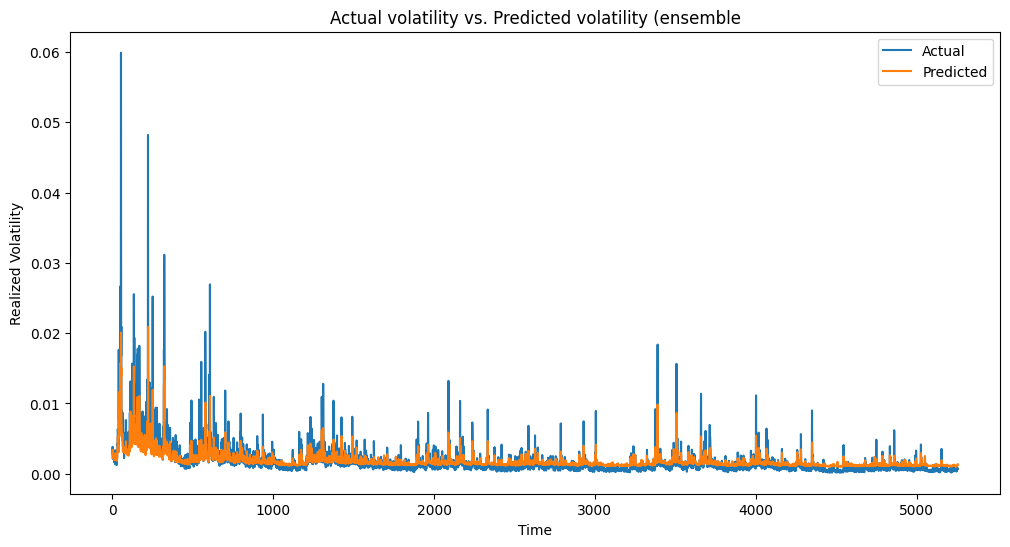

In [55]:
# Visualize actual volatility values vs. ensemble predictions
# y_pred_cnn_lstm = cnn_lstm_model.model.predict(X_test_cnn_lstm)
y_pred_ensemble = ensemble_model.predict(X_test)
ensemble_model.visualize_ensemble_prediction(y_test, y_pred_ensemble)

## Visualizations

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_35 (TimeDi  (None, None, 1, 128)     5248      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, None, 1, 128)     0         
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, None, 1, 64)      8256      
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, None, 1, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, None, 1, 32)     

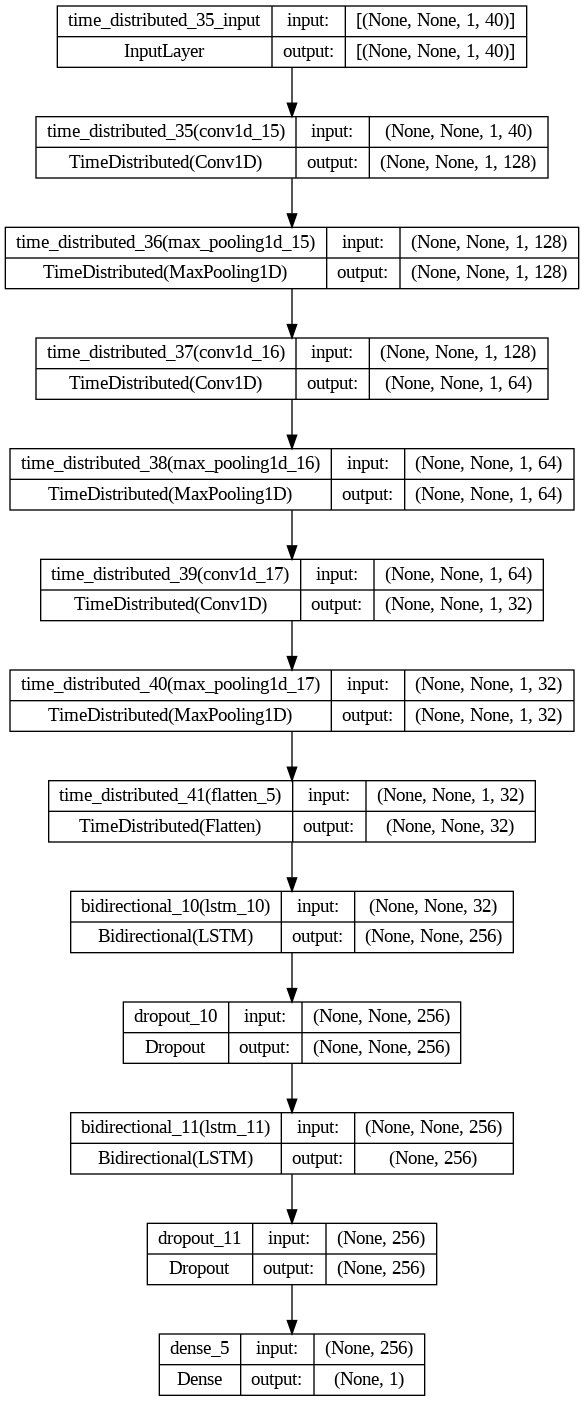

In [56]:
print(cnn_lstm_model.model.summary())
plot_model(cnn_lstm_model.model, to_file='cnn_lstm_model_model.png', show_shapes=True, show_layer_names=True)


<ipython-input-51-82d342a44416>:268: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


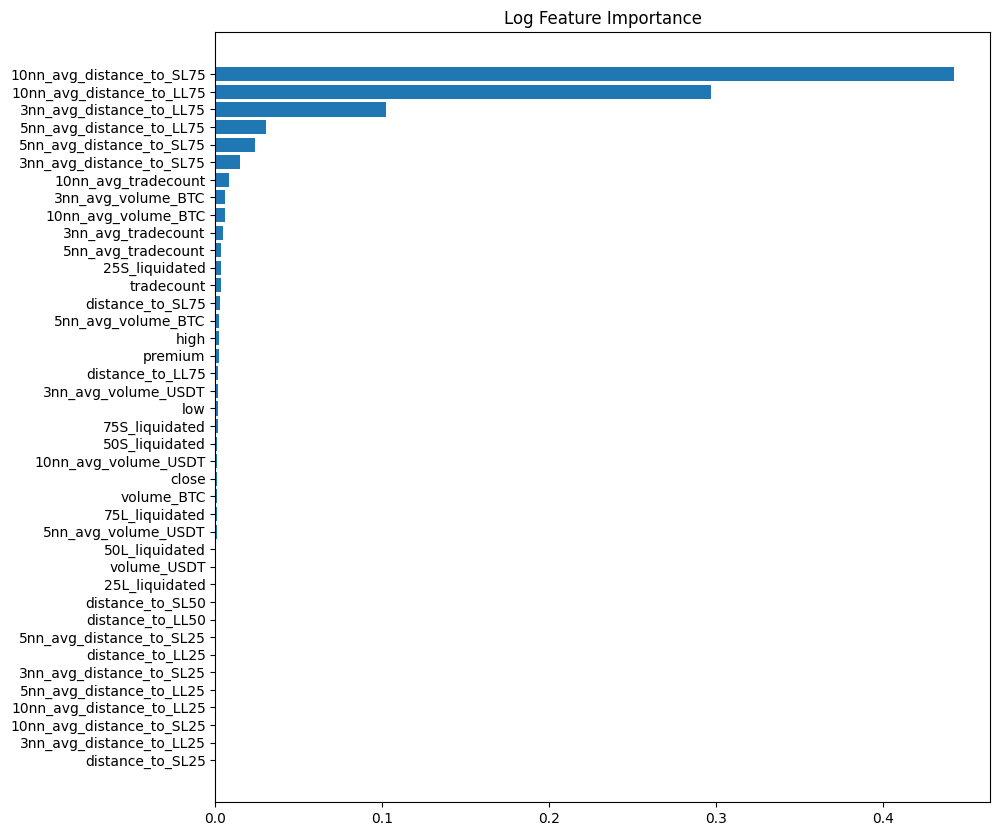

In [57]:
X_train_df = train_data[feature_cols]
lgbm_model.plot_feature_importance(X_train_df)